# _Examinationsarbete i Deep Learning_

**Project $alpha$**

Målbild:

- Designa och träna Convolutional Neural Networks (CNNs) från grunden, för att klassificera bilder i CIFAR-10 datasetet.

Generella och specifika kraven för betygsgränser beskrivs längre ner.

---


## _Dataset, CIFAR-10_


- **Antal bilder:** 60,000 (32x32 pixlar, färgbilder).
- **Klasser:** 10 klasser (t.ex. flygplan, bil, fågel, katt).
- **Uppdelning:**
  - Träning: 50,000 bilder.
  - Test: 10,000 bilder.

**Evalueringskrav**

Datasetet ska laddas in från PyTorchs `torchvision` bibliotek, och tillhörande testset ska användas för evaluering.


---

**Project $alpha$**

Här ska ni designa och träna Convolutional Neural Networks (CNNs) från grunden, i syfte att klassificera bilder i CIFAR-10-datasetet.

**Krav för G:**

- Mellan **75-80% accuracy** på test-settet.
- Designa, träna och evaluera minst **tre olika CNN-arkitekturer**.
- Prestandan av varje färdigtränad modell ska vara tydlig, och även loss-kurvor ska plottas - följt av en kortfattad analys av dessa.
- I varje CNN-klass ska, i `forward`-metoden, **storleken på input och output för varje operation** skrivas ut som en kommentar.
- Gör dessutom en **kvalitativ analys** av dina modellers prestanda (vilka klasser presteras bra på, och vilka dåligt) - och varför, om möjligt.

**Krav för VG:**

- Uppnår kraven för **G**, och når **85%+ accuracy** på test-settet.
- Ni använder dessutom flertalet metoder under träningen som ni själva läst på och lärt er om, exempelvis via litteraturhänvisningen.
  - samtliga metoder, utöver de vi gått igenom i klassen, som ni väljer att använda ska ni i ett särskilt stycke i er notebook, förklara (så gott ni kan)
    samt ge referenser till.
- Ni ska även att utföra en ordentlig error analysis, på er bäst presterade modell.

**Krav för Guldstjärna:**

- Uppnår kraven för **VG**, och når **90%+ accuracy** på test-settet.


Var kreativa med era arkitekturer. Ni behöver exempelvis inte begränsa er till det 'normala' convolutional block som vi
lärde oss under föreläsningarna (dvs conv layer + relu följt av pooling), utan det kan se annorlunda ut. Se litteraturhänvisningarna för inspiration från kända CNN-arkitekturer som ex. AlexNet, VGG, ResNet etc.

Utöver det finns det andra knep man kan integrera in i sin CNN som empiriskt visat förbättra prestanda. Exempelvis:

- Batch Normalization
- Data Augmentation
- Alternativa Optimizers (ex Adam, RMSprop)
- Learning Rate Scheduling

Ni har friheten att själva söka information om dessa och hur de implementeras i PyTorch, för att sedan nyttja dem i ert projekt.


**Pre-trained models & Transfer Learning**

Kraven för alla betyg (och Guldstjärnan) går att uppnå med att träna modeller från grunden, men ni får givetvis även försöka er på att använda en pre-trained model om ni vill. Men, ni får inte **enbart** använda pre-trained models (max antal: 1).

Det kan dock vara rätt beräkningstungt.


---

**Inlämning**


Ni lämnar in en notebook fil som innehåller allt arbete. Notebooken ska dessutom sparas med alla outputen kvarstående!

Mao ska jag bara kunna bläddra igenom er notebook för att se allt arbete och alla output, utan att för den delen köra koden själv.

Spara notebook:en med namnet **{namn}\_{efternamn}\_{alpha}.ipynb**, och skicka därefter in via ITHS-portalen.


---

**Literaturlista**

Följande research ger både en inblick i historiken av CNN-arkitekturers utveckling, och kan ge idéer om nyttiga idéer i era egna projekt:

- [**LeNet-5**](http://yann.lecun.com/exdb/lenet/). Grundläggande arbete som introducer konceptet med Convolutional Neural Networks.
- [**AlexNet**](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). Vann ImageNet-tävlingen 2012, genom att bland annat introducera "ReLU".
- [**VGGNet**](https://arxiv.org/abs/1409.1556).
- [**GoogLeNet**](https://arxiv.org/abs/1409.4842). Introducerade "Inception"-modulen (aka "bottle-neck layer").
- [**ResNet**](http://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). Introducerar "skip connections" som hjälper djupa nätverk att lära sig.
- [**EfficientNet**](https://arxiv.org/abs/1905.11946)

Ni kan givetvis lära er mer om dessa koncept genom att söka efter alternativa källor också.


---

# 🚀 Imports


In [31]:
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim import Adam,RMSprop,Optimizer
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Subset
from torch.nn import Module, CrossEntropyLoss
from typing import List
import os
from typing import List, Dict

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

import random
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow


import warnings

warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

---

# 🛠️ Utilities & Helper Functions


In [4]:
def visualize_loader(loader, mean=None, std=None, title="Visualization"):
    """
    Visualize a batch of images from a DataLoader.

    Args:
        loader (torch.utils.data.DataLoader): The DataLoader to visualize.
        mean (list or tensor, optional): Mean for denormalization.
        std (list or tensor, optional): Std for denormalization.
        title (str): Title for the plot.
    """
    # Fetch one batch from the loader
    images, labels = next(iter(loader))

    # Denormalize if mean and std are provided
    if mean is not None and std is not None:
        mean = np.array(mean).reshape(1, 3, 1, 1)
        std = np.array(std).reshape(1, 3, 1, 1)
        images = images * torch.tensor(std).to(images.device) + torch.tensor(mean).to(images.device)

    # Create a grid of images
    fullgrid = torchvision.utils.make_grid(images)

    # Convert to NumPy for visualization
    img = fullgrid.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)  # Ensure valid range for plotting

    # Display the image
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [5]:
def get_mean_std(loader):
    """Calculate the mean and standard deviation for each channel."""
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)  # Number of images in the batch
        images = images.view(batch_samples, 3, -1)  # Flatten HxW, preserve channels

        mean += images.mean(dim=[0, 2]) * batch_samples  # Mean per channel
        std += images.std(dim=[0, 2]) * batch_samples  # Std per channel
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean, std

In [32]:
def train_and_evaluate(
    model: Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: Optimizer,
    criterion: CrossEntropyLoss,
    scheduler: StepLR,
    epochs: int = 50,
    model_name: str = "Model",
    save_path: str = "./models"
) -> Dict[str, List[float]]:
    """
    Train and evaluate a given model with specified hyperparameters.

    Additionally saves the best model and returns metrics for comparison.

    Parameters:
    - model (Module): PyTorch model to be trained.
    - train_loader (DataLoader): DataLoader for training data.
    - test_loader (DataLoader): DataLoader for testing data.
    - optimizer (Optimizer): Optimizer for model training.
    - criterion (CrossEntropyLoss): Loss function.
    - scheduler (StepLR): Learning rate scheduler.
    - epochs (int): Number of training epochs.
    - model_name (str): Name of the model for identification.
    - save_path (str): Directory to save the best model.

    Returns:
    - metrics (Dict[str, List[float]]): Contains train losses, test losses, and test accuracies.
    """
    # Initialize tracking variables
    epoch_train_losses: List[float] = []
    epoch_evaluation_losses: List[float] = []
    epoch_evaluation_accuracies: List[float] = []
    best_test_accuracy = 0.0
    best_model_state = None

    # Ensure save directory exists
    os.makedirs(save_path, exist_ok=True)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss: float = 0.0
        correct_train: int = 0
        total_train: int = 0

        print(f"Epoch {epoch + 1}/{epochs} (Learning Rate: {scheduler.get_last_lr()[0]:.6f})")
        for input_features, y_true in tqdm(train_loader, desc="Training", leave=False):
            input_features, y_true = input_features.to(device), y_true.to(device)

            optimizer.zero_grad()
            y_pred = model(input_features)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted_class = torch.max(y_pred, 1)
            correct_train += (predicted_class == y_true).sum().item()
            total_train += y_true.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        epoch_train_losses.append(train_loss)

        # Scheduler Step
        scheduler.step()

        # Evaluation Phase
        model.eval()
        test_loss: float = 0.0
        correct_test: int = 0
        total_test: int = 0

        with torch.no_grad():
            for input_features, y_true in tqdm(test_loader, desc="Evaluating", leave=False):
                input_features, y_true = input_features.to(device), y_true.to(device)

                y_pred = model(input_features)
                loss = criterion(y_pred, y_true)
                test_loss += loss.item()

                _, predicted_class = torch.max(y_pred, 1)
                correct_test += (predicted_class == y_true).sum().item()
                total_test += y_true.size(0)

        test_loss /= len(test_loader)
        test_accuracy = correct_test / total_test
        epoch_evaluation_losses.append(test_loss)
        epoch_evaluation_accuracies.append(test_accuracy)

        # Save the best model
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state = model.state_dict()
            torch.save(best_model_state, os.path.join(save_path, f"{model_name}_best.pth"))

        # Epoch Summary
        print(
            f"Epoch {epoch + 1}/{epochs}: "
            f"Train Loss = {train_loss:.4f}, "
            f"Train Accuracy = {train_accuracy:.4f}, "
            f"Test Loss = {test_loss:.4f}, "
            f"Test Accuracy = {test_accuracy:.4f}, "
            f"Learning Rate = {scheduler.get_last_lr()[0]:.6f}"
        )

    # Training & Evaluation Plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, len(epoch_evaluation_losses) + 1), epoch_evaluation_losses, label="Test Loss", marker="o", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name}: Train vs Test Loss per Epoch")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(epoch_evaluation_accuracies) + 1), epoch_evaluation_accuracies, label="Test Accuracy", marker="o", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name}: Test Accuracy per Epoch")
    plt.legend()
    plt.grid()
    plt.show()

    # Return all metrics for comparison
    return {
        "train_losses": epoch_train_losses,
        "test_losses": epoch_evaluation_losses,
        "test_accuracies": epoch_evaluation_accuracies,
    }


In [62]:
def plot_confusion_matrix(model: nn.Module, dataloader, classes: list, device: str):
    """
    Plot confusion matrix for the model.
    Args:
        model (nn.Module): Trained model.
        dataloader: DataLoader for evaluation.
        classes (list): List of class names.
        device (str): Device to run inference on.
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)

    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.title("Confusion Matrix")
    plt.show()


In [61]:
def classification_report_per_class(model, dataloader, classes, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=classes)
    print(report)


In [9]:
def visualize_misclassified_class(model: nn.Module,
                                  dataloader: torch.utils.data.DataLoader,
                                  classes: list,
                                  device: torch.device,
                                  mean: torch.Tensor,
                                  std: torch.Tensor,
                                  target_class: str = "cat"):
    """
    Visualize misclassified images for a specific true label (e.g., 'cat').
    """
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    mean = mean.numpy()  # Convert to NumPy array
    std = std.numpy()    # Convert to NumPy array

    target_index = classes.index(target_class)  # Find the index of the target class

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Identify misclassified images for the target class
            for i in range(inputs.size(0)):
                if labels[i] == target_index and preds[i] != target_index:
                    misclassified_images.append(inputs[i].cpu())
                    true_labels.append(labels[i].cpu())
                    predicted_labels.append(preds[i].cpu())

            # Stop if we have enough misclassified examples to display
            if len(misclassified_images) >= 16:
                break

    # Plot misclassified images
    if len(misclassified_images) == 0:
        print(f"No misclassifications found for class '{target_class}'.")
        return

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        if i >= len(misclassified_images):
            ax.axis('off')
            continue

        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = img * std[None, None, :] + mean[None, None, :]  # Denormalize
        img = np.clip(img, 0, 1)  # Ensure valid pixel values

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(
            f"True: {classes[true_labels[i]]}\nPred: {classes[predicted_labels[i]]}"
        )

    plt.tight_layout()
    plt.show()


In [10]:
def visualize_misclassified_images(model: nn.Module,
                                   dataloader: torch.utils.data.DataLoader,
                                   classes: list,
                                   device: torch.device,
                                   mean: torch.Tensor,
                                   std: torch.Tensor):
    """
    Visualize misclassified images from a model on a dataset.
    """
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    true_labels = []
    predicted_labels = []

    mean = mean.numpy()  # Convert to NumPy array
    std = std.numpy()    # Convert to NumPy array

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Identify misclassified images
            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    misclassified_images.append(inputs[i].cpu())
                    true_labels.append(labels[i].cpu())
                    predicted_labels.append(preds[i].cpu())

            # Stop if we have enough misclassified examples to display
            if len(misclassified_images) >= 16:
                break

    # Plot misclassified images
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = img * std[None, None, :] + mean[None, None, :]  # Denormalize
        img = np.clip(img, 0, 1)  # Ensure valid pixel values

        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {classes[true_labels[i]]}\nPred: {classes[predicted_labels[i]]}")

    plt.tight_layout()
    plt.show()


---

# 📊 Define Data Variables


In [11]:
stat_dataset = torchvision.datasets.CIFAR10(
    root='./data/', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/


In [12]:
stat_dataloader = torch.utils.data.DataLoader(
    stat_dataset, batch_size=128, shuffle=True)
mean, std = get_mean_std(stat_dataloader)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2467, 0.2432, 0.2612])


In [33]:
# Train Transforms (Different per model)
train_transform_alpha = transforms.Compose([
    # 📊 Normalization
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_transform_beta = transforms.Compose([
    # 🔄 Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),

    # 📊 Normalization
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


train_transform_omega = transforms.Compose([
    # 🔄 Data Augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    # 📊 Normalization
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Normalisering
])

# Test Transform - Endast Normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Normalisering
])


# Raw Dataset (No Transformations)
raw_transform = transforms.Compose([
    transforms.ToTensor()
])

In [34]:
# Shared Test Dataset
testset = torchvision.datasets.CIFAR10(
    root='./data/', train=False, download=True, transform=test_transform)


# Model-Specific Train Datasets
train_dataset_alpha = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_alpha)

train_dataset_beta = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_beta)

train_dataset_omega = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform_omega)

# Raw
raw_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=raw_transform
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [35]:
# Ensure the same subset indices across raw, train, and test datasets
visualization_indices = list(range(16))

# Visualization Subsets
raw_subset = Subset(raw_dataset, visualization_indices)
test_subset = Subset(testset, visualization_indices)

# Model-Specific Train Subsets
train_subset_alpha = Subset(train_dataset_alpha, visualization_indices)
train_subset_beta = Subset(train_dataset_beta, visualization_indices)
train_subset_omega = Subset(train_dataset_omega, visualization_indices)

In [16]:
__, height, width, channels = testset.data.shape
class_names = testset.classes
classes = len(class_names)

In [36]:
# Check the dataset shapes and lengths
print("📊 Dataset Validation:")
print(f"Raw Dataset Shape: {raw_dataset[0][0].shape}")  # Should be [3, 32, 32]
print(f"Raw Dataset Length: {len(raw_dataset)}")       # Should be ~50,000 images

print(f"Train Dataset (Alpha) Length: {len(train_dataset_alpha)}")
print(f"Train Dataset (Beta) Length: {len(train_dataset_beta)}")
print(f"Train Dataset (Omega) Length: {len(train_dataset_omega)}")
print(f"Test Dataset Length: {len(testset)}")

📊 Dataset Validation:
Raw Dataset Shape: torch.Size([3, 32, 32])
Raw Dataset Length: 50000
Train Dataset (Alpha) Length: 50000
Train Dataset (Beta) Length: 50000
Train Dataset (Omega) Length: 50000
Test Dataset Length: 10000


In [18]:
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---

# 📦 Define Data Loaders


In [37]:
# Shared Test Dataset
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

# Model-Specific Train Datasets
train_loader_alpha = DataLoader(train_dataset_alpha, batch_size=128, shuffle=True)

train_loader_beta = DataLoader(train_dataset_beta, batch_size=128, shuffle=True)

train_loader_omega = DataLoader(train_dataset_omega, batch_size=128, shuffle=True)

In [38]:
print("\n📊 Dataset Loader Validation:")
print(f"Train Loader Alpha Length (batches): {len(train_loader_alpha)}")
print(f"Train Loader Beta Length (batches): {len(train_loader_beta)}")
print(f"Train Loader Omega Length (batches): {len(train_loader_omega)}")
print(f"Test Loader Length (batches): {len(test_loader)}")



📊 Dataset Loader Validation:
Train Loader Alpha Length (batches): 391
Train Loader Beta Length (batches): 391
Train Loader Omega Length (batches): 391
Test Loader Length (batches): 79


In [39]:
# Loaders for visualization
raw_loader = torch.utils.data.DataLoader(raw_subset, batch_size=16, shuffle=False)
test_loader_viz = torch.utils.data.DataLoader(test_subset, batch_size=16, shuffle=False)
train_loader_alpha_viz = torch.utils.data.DataLoader(train_subset_alpha, batch_size=16, shuffle=False)
train_loader_beta_viz = torch.utils.data.DataLoader(train_subset_beta, batch_size=16, shuffle=False)
train_loader_omega_viz = torch.utils.data.DataLoader(train_subset_omega, batch_size=16, shuffle=False)


In [40]:
# Print Dataset Lengths for Visualization
print("\n🛠️ Visualization Loader Lengths:")
print(f"Raw Loader Length: {len(raw_loader)}")
print(f"Test Loader Length: {len(test_loader_viz)}")
print(f"Train Loader Alpha Length: {len(train_loader_alpha_viz)}")
print(f"Train Loader Beta Length: {len(train_loader_beta_viz)}")
print(f"Train Loader Omega Length: {len(train_loader_omega_viz)}")



🛠️ Visualization Loader Lengths:
Raw Loader Length: 1
Test Loader Length: 1
Train Loader Alpha Length: 1
Train Loader Beta Length: 1
Train Loader Omega Length: 1


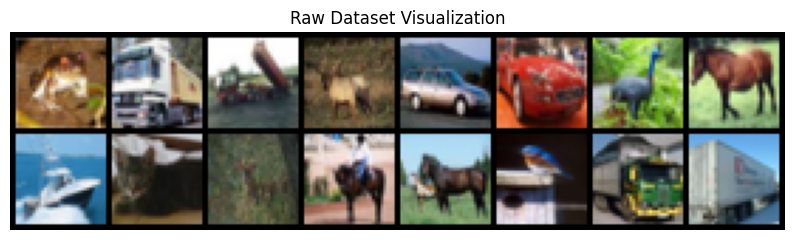

In [23]:
visualize_loader(raw_loader, title="Raw Dataset Visualization")

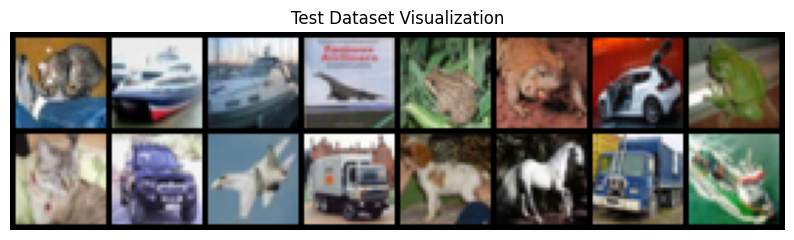

In [24]:
visualize_loader(test_loader_viz, mean=mean, std=std, title="Test Dataset Visualization")

---

# 🧠 Model Definitions


## 1. 🛡️AlphaNet


### 🔧 Architecture


In [41]:
class AlphaNet(nn.Module):
    def __init__(self):
        super(AlphaNet, self).__init__()

        # 📦 Feature Extractor
        self.feature_extractor = nn.Sequential(
            # 🧠 Block 1
            self._conv_block(channels, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce to 64x16x16


            # 🧠 Block 2
            self._conv_block(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce to 128x8x8


        )

        # 📝 Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),

            nn.Linear(128, classes)
        )

    def _conv_block(self, in_channels, out_channels):
        """Two-layer convolutional block with BatchNorm and ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


### 🛠️ Initialization


In [51]:
# 🧠 Model, Optimizer, Criterion, and Scheduler
alpha_model = AlphaNet().to(device)
alphanet_optimizer = Adam(alpha_model.parameters(), lr=0.001)
alphanet_criterion = torch.nn.CrossEntropyLoss()

# Define StepLR scheduler
alphanet_scheduler = StepLR(alphanet_optimizer, step_size=10, gamma=0.1)

### 🖼️ Dataset Visualization


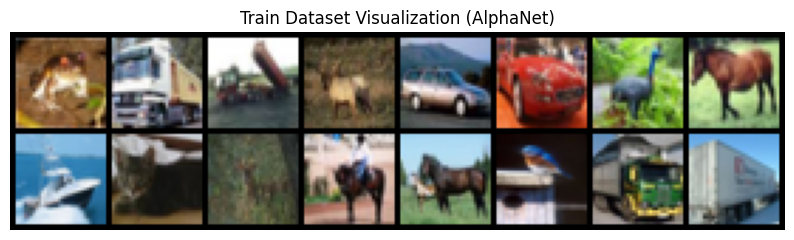

In [43]:
visualize_loader(train_loader_alpha_viz, mean, std, title="Train Dataset Visualization (AlphaNet)")

This shows the images AlphaNet will train on above we had raw and test sets which is the same in how it looks


### 🚀 Training


Epoch 1/30 (Learning Rate: 0.001000)


Epoch 1/30: Train Loss = 1.3542, Train Accuracy = 0.5103, Test Loss = 1.0000, Test Accuracy = 0.6454, Learning Rate = 0.001000
Epoch 2/30 (Learning Rate: 0.001000)


Epoch 2/30: Train Loss = 0.8613, Train Accuracy = 0.6966, Test Loss = 0.7915, Test Accuracy = 0.7228, Learning Rate = 0.001000
Epoch 3/30 (Learning Rate: 0.001000)


Epoch 3/30: Train Loss = 0.6539, Train Accuracy = 0.7702, Test Loss = 0.7238, Test Accuracy = 0.7461, Learning Rate = 0.001000
Epoch 4/30 (Learning Rate: 0.001000)


Epoch 4/30: Train Loss = 0.5069, Train Accuracy = 0.8229, Test Loss = 0.6740, Test Accuracy = 0.7714, Learning Rate = 0.001000
Epoch 5/30 (Learning Rate: 0.001000)


Epoch 5/30: Train Loss = 0.3754, Train Accuracy = 0.8686, Test Loss = 0.7340, Test Accuracy = 0.7739, Learning Rate = 0.001000
Epoch 6/30 (Learning Rate: 0.001000)


Epoch 6/30: Train Loss = 0.2705, Train Accuracy = 0.9040, Test Loss = 0.8030, Test Accuracy = 0.7675, Learning Rate = 0.001000
Epoch 7/30 (Learning Rate: 0.001000)


Epoch 7/30: Train Loss = 0.1840, Train Accuracy = 0.9360, Test Loss = 0.8898, Test Accuracy = 0.7681, Learning Rate = 0.001000
Epoch 8/30 (Learning Rate: 0.001000)


Epoch 8/30: Train Loss = 0.1296, Train Accuracy = 0.9537, Test Loss = 1.0090, Test Accuracy = 0.7696, Learning Rate = 0.001000
Epoch 9/30 (Learning Rate: 0.001000)


Epoch 9/30: Train Loss = 0.1062, Train Accuracy = 0.9623, Test Loss = 1.1278, Test Accuracy = 0.7656, Learning Rate = 0.001000
Epoch 10/30 (Learning Rate: 0.001000)


Epoch 10/30: Train Loss = 0.0866, Train Accuracy = 0.9706, Test Loss = 1.3111, Test Accuracy = 0.7630, Learning Rate = 0.000100
Epoch 11/30 (Learning Rate: 0.000100)


Epoch 11/30: Train Loss = 0.0226, Train Accuracy = 0.9936, Test Loss = 1.2563, Test Accuracy = 0.7813, Learning Rate = 0.000100
Epoch 12/30 (Learning Rate: 0.000100)


Epoch 12/30: Train Loss = 0.0068, Train Accuracy = 0.9995, Test Loss = 1.3480, Test Accuracy = 0.7813, Learning Rate = 0.000100
Epoch 13/30 (Learning Rate: 0.000100)


Epoch 13/30: Train Loss = 0.0038, Train Accuracy = 0.9999, Test Loss = 1.4138, Test Accuracy = 0.7808, Learning Rate = 0.000100
Epoch 14/30 (Learning Rate: 0.000100)


Epoch 14/30: Train Loss = 0.0025, Train Accuracy = 1.0000, Test Loss = 1.4901, Test Accuracy = 0.7817, Learning Rate = 0.000100
Epoch 15/30 (Learning Rate: 0.000100)


Epoch 15/30: Train Loss = 0.0018, Train Accuracy = 1.0000, Test Loss = 1.5472, Test Accuracy = 0.7823, Learning Rate = 0.000100
Epoch 16/30 (Learning Rate: 0.000100)


Epoch 16/30: Train Loss = 0.0013, Train Accuracy = 1.0000, Test Loss = 1.6087, Test Accuracy = 0.7827, Learning Rate = 0.000100
Epoch 17/30 (Learning Rate: 0.000100)


Epoch 17/30: Train Loss = 0.0010, Train Accuracy = 1.0000, Test Loss = 1.6596, Test Accuracy = 0.7822, Learning Rate = 0.000100
Epoch 18/30 (Learning Rate: 0.000100)


Epoch 18/30: Train Loss = 0.0007, Train Accuracy = 1.0000, Test Loss = 1.7191, Test Accuracy = 0.7819, Learning Rate = 0.000100
Epoch 19/30 (Learning Rate: 0.000100)


Epoch 19/30: Train Loss = 0.0005, Train Accuracy = 1.0000, Test Loss = 1.7726, Test Accuracy = 0.7826, Learning Rate = 0.000100
Epoch 20/30 (Learning Rate: 0.000100)


Epoch 20/30: Train Loss = 0.0004, Train Accuracy = 1.0000, Test Loss = 1.8270, Test Accuracy = 0.7830, Learning Rate = 0.000010
Epoch 21/30 (Learning Rate: 0.000010)


Epoch 21/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8338, Test Accuracy = 0.7829, Learning Rate = 0.000010
Epoch 22/30 (Learning Rate: 0.000010)


Epoch 22/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8405, Test Accuracy = 0.7831, Learning Rate = 0.000010
Epoch 23/30 (Learning Rate: 0.000010)


Epoch 23/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8488, Test Accuracy = 0.7832, Learning Rate = 0.000010
Epoch 24/30 (Learning Rate: 0.000010)


Epoch 24/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8585, Test Accuracy = 0.7829, Learning Rate = 0.000010
Epoch 25/30 (Learning Rate: 0.000010)


Epoch 25/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8687, Test Accuracy = 0.7830, Learning Rate = 0.000010
Epoch 26/30 (Learning Rate: 0.000010)


Epoch 26/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8818, Test Accuracy = 0.7829, Learning Rate = 0.000010
Epoch 27/30 (Learning Rate: 0.000010)


Epoch 27/30: Train Loss = 0.0003, Train Accuracy = 1.0000, Test Loss = 1.8961, Test Accuracy = 0.7827, Learning Rate = 0.000010
Epoch 28/30 (Learning Rate: 0.000010)


Epoch 28/30: Train Loss = 0.0002, Train Accuracy = 1.0000, Test Loss = 1.9115, Test Accuracy = 0.7830, Learning Rate = 0.000010
Epoch 29/30 (Learning Rate: 0.000010)


Epoch 29/30: Train Loss = 0.0002, Train Accuracy = 1.0000, Test Loss = 1.9290, Test Accuracy = 0.7829, Learning Rate = 0.000010
Epoch 30/30 (Learning Rate: 0.000010)


Epoch 30/30: Train Loss = 0.0002, Train Accuracy = 1.0000, Test Loss = 1.9503, Test Accuracy = 0.7832, Learning Rate = 0.000001


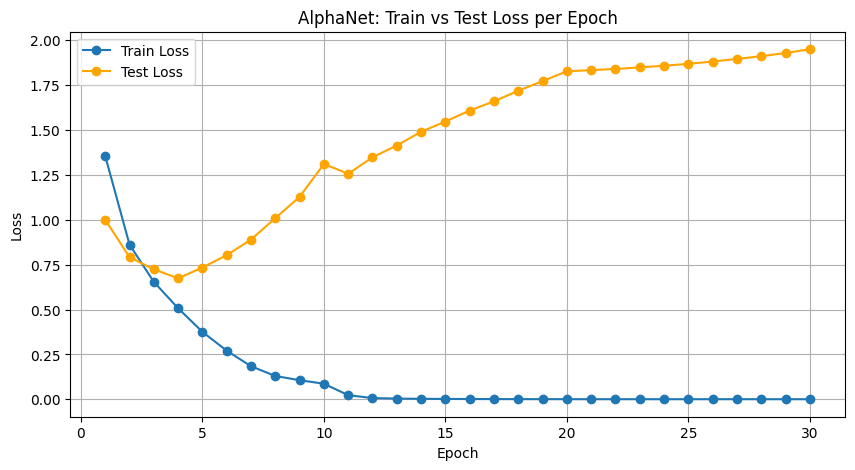

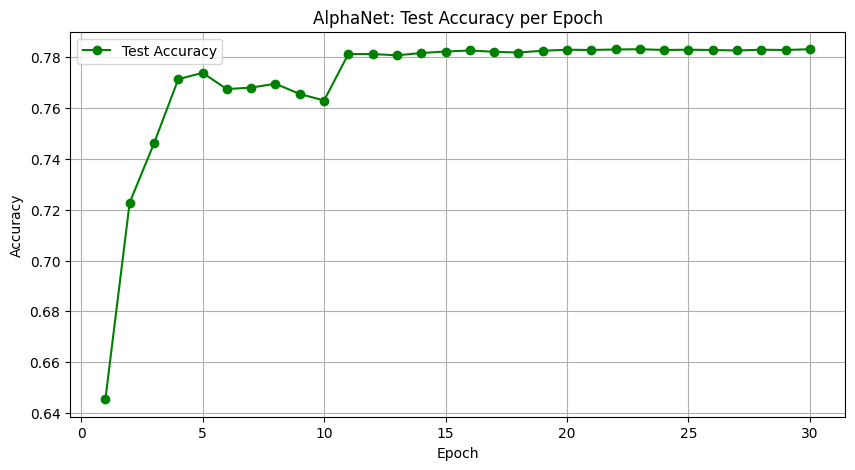

In [52]:
alpha_metrics = train_and_evaluate(
    model=alpha_model,
    train_loader=train_loader_alpha,
    test_loader=test_loader,
    optimizer=alphanet_optimizer,
    criterion=alphanet_criterion,
    scheduler=alphanet_scheduler,
    epochs=30,
    model_name="AlphaNet"
)

### 📊 Analysis


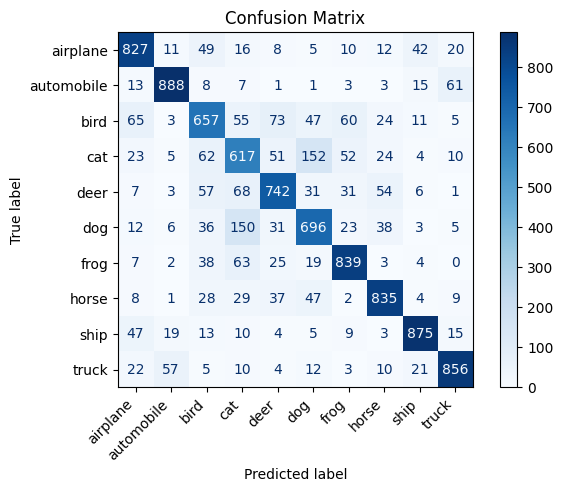

In [63]:
plot_confusion_matrix(alpha_model, test_loader, class_names, device)


In [54]:
classification_report_per_class(alpha_model, test_loader, class_names, device)


              precision    recall  f1-score   support

    airplane       0.80      0.83      0.81      1000
  automobile       0.89      0.89      0.89      1000
        bird       0.69      0.66      0.67      1000
         cat       0.60      0.62      0.61      1000
        deer       0.76      0.74      0.75      1000
         dog       0.69      0.70      0.69      1000
        frog       0.81      0.84      0.83      1000
       horse       0.83      0.83      0.83      1000
        ship       0.89      0.88      0.88      1000
       truck       0.87      0.86      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



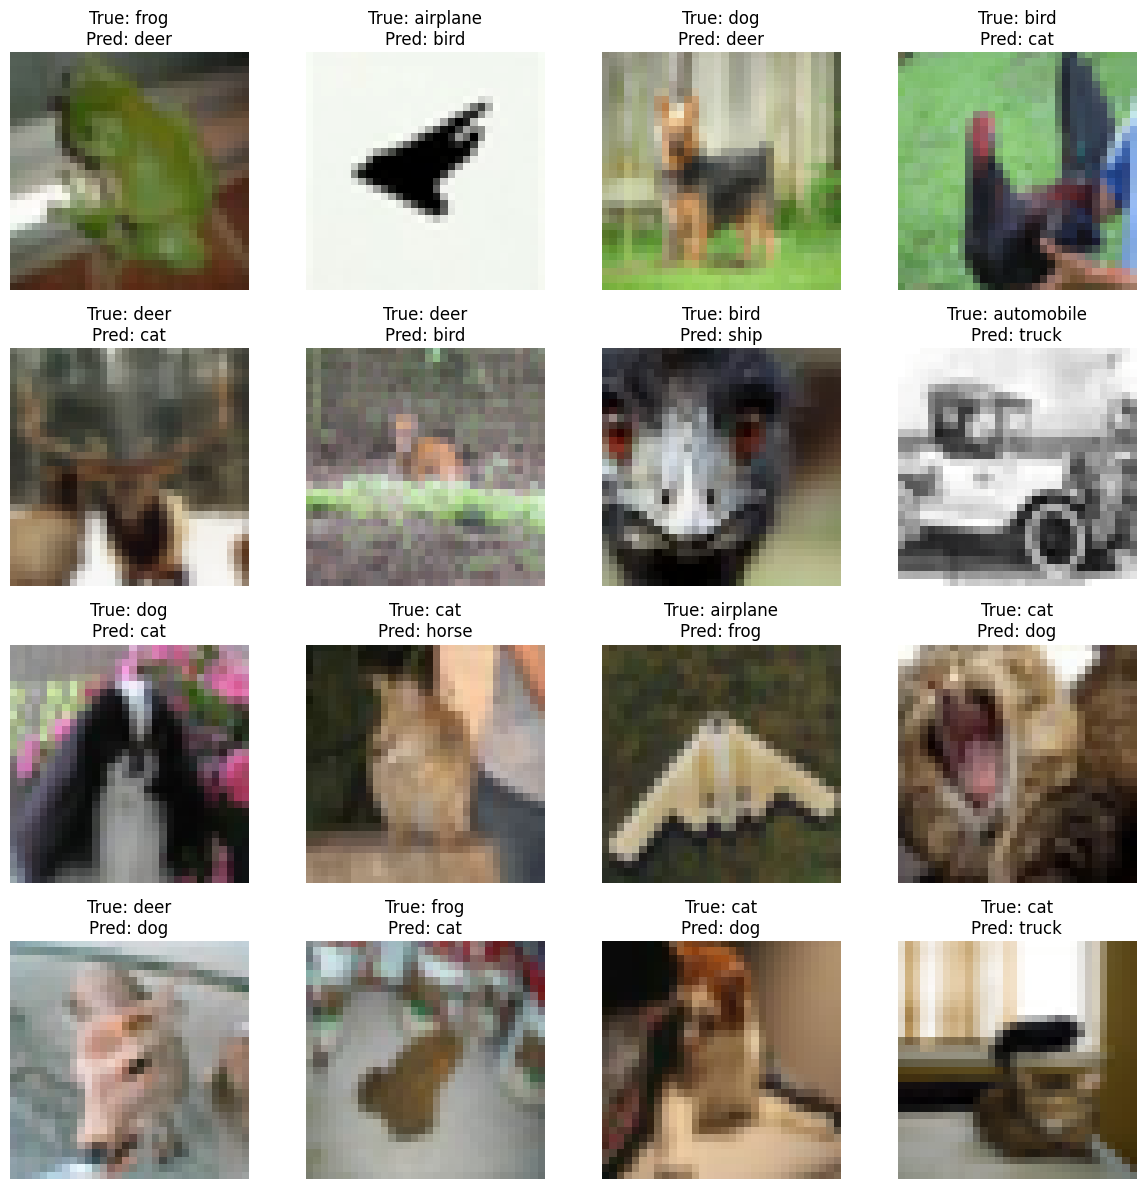

In [55]:
visualize_misclassified_images(alpha_model, test_loader, class_names, device, mean, std)


**📝 Performance Overview**

- AlphaNet meets the requirements for **G-level performance**, performing well in **vehicle classification** but struggling significantly with **animal classes**, especially **cats**.
- This misclassification may stem from visual similarities between **cats, birds, and dogs**.

---

**✅ Strengths**

- Strong performance on **vehicle classes** (_automobiles, trucks, ships_).
- **Simple and computationally efficient architecture**.

**❌ Weaknesses**

- Poor accuracy on **cats**, followed by **birds** and **dogs**.
- Clear signs of **overfitting** due to the absence of **batch normalization** and **dropout layers**.
- The model uses a **data loader without any augmentation**, limiting its generalization capability.

---

**🏗️ Architecture Summary**

- **2 convolutional blocks**, each containing:
  - **2 convolutional layers**
  - **MaxPooling** for downsampling
- **2 fully connected layers** in the classifier
- The model relies on a **data loader without augmentation**.

---

**📊 Suggestions for Improvement**

- Apply **data augmentation** to improve generalization.
- Introduce **batch normalization** for training stability.
- Add **dropout layers** to reduce overfitting.

**🧠 Conclusion:**  
AlphaNet demonstrates a solid **baseline performance** but is constrained by its simplistic design and lack of regularization. With enhancements in **data augmentation**, **batch normalization**, and **dropout**, the model has the potential for significant improvement.


## 2. 🛡️BetaNet


### 🔧 Architecture


In [56]:
class BetaNet(nn.Module):
    def __init__(self):
        super(BetaNet, self).__init__()

        # 📦 Feature Extractor
        self.feature_extractor = nn.Sequential(
            # 🧠 Block 1
            self._conv_block(channels, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce to 64x16x16


            # 🧠 Block 2
            self._conv_block(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce to 128x8x8

            # 🧠 Block 3
            self._conv_block(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Reduce to 256x4x4

        )

        # 📝 Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),

            nn.Linear(256, classes)
        )

    def _conv_block(self, in_channels, out_channels):
        """Two-layer convolutional block with BatchNorm and ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


### 🛠️ Initialization


In [57]:
# 🧠 Model, Optimizer, Criterion, and Scheduler
betanet_model = BetaNet().to(device)
betanet_optimizer = Adam(betanet_model.parameters(), lr=0.001)
betanet_criterion = torch.nn.CrossEntropyLoss()

# Define StepLR scheduler
betanet_scheduler = StepLR(betanet_optimizer, step_size=10, gamma=0.1)

### 🖼️ Dataset Visualization


Data training on


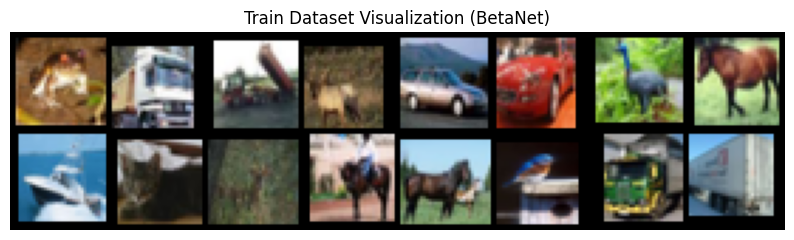

In [58]:
visualize_loader(train_loader_beta_viz, mean, std, title="Train Dataset Visualization (BetaNet)")

### 🚀 Training


Epoch 1/30 (Learning Rate: 0.001000)


Epoch 1/30: Train Loss = 1.6629, Train Accuracy = 0.3778, Test Loss = 1.2293, Test Accuracy = 0.5518, Learning Rate = 0.001000
Epoch 2/30 (Learning Rate: 0.001000)


Epoch 2/30: Train Loss = 1.1618, Train Accuracy = 0.5777, Test Loss = 1.0221, Test Accuracy = 0.6377, Learning Rate = 0.001000
Epoch 3/30 (Learning Rate: 0.001000)


Epoch 3/30: Train Loss = 0.9438, Train Accuracy = 0.6611, Test Loss = 0.8072, Test Accuracy = 0.7158, Learning Rate = 0.001000
Epoch 4/30 (Learning Rate: 0.001000)


Epoch 4/30: Train Loss = 0.7978, Train Accuracy = 0.7160, Test Loss = 0.7526, Test Accuracy = 0.7366, Learning Rate = 0.001000
Epoch 5/30 (Learning Rate: 0.001000)


Epoch 5/30: Train Loss = 0.7028, Train Accuracy = 0.7537, Test Loss = 0.6852, Test Accuracy = 0.7637, Learning Rate = 0.001000
Epoch 6/30 (Learning Rate: 0.001000)


Epoch 6/30: Train Loss = 0.6330, Train Accuracy = 0.7781, Test Loss = 0.6379, Test Accuracy = 0.7862, Learning Rate = 0.001000
Epoch 7/30 (Learning Rate: 0.001000)


Epoch 7/30: Train Loss = 0.5761, Train Accuracy = 0.7980, Test Loss = 0.5993, Test Accuracy = 0.8020, Learning Rate = 0.001000
Epoch 8/30 (Learning Rate: 0.001000)


Epoch 8/30: Train Loss = 0.5328, Train Accuracy = 0.8156, Test Loss = 0.5818, Test Accuracy = 0.8009, Learning Rate = 0.001000
Epoch 9/30 (Learning Rate: 0.001000)


Epoch 9/30: Train Loss = 0.4939, Train Accuracy = 0.8252, Test Loss = 0.5256, Test Accuracy = 0.8211, Learning Rate = 0.001000
Epoch 10/30 (Learning Rate: 0.001000)


Epoch 10/30: Train Loss = 0.4675, Train Accuracy = 0.8354, Test Loss = 0.5246, Test Accuracy = 0.8258, Learning Rate = 0.000100
Epoch 11/30 (Learning Rate: 0.000100)


Epoch 11/30: Train Loss = 0.3663, Train Accuracy = 0.8718, Test Loss = 0.4624, Test Accuracy = 0.8461, Learning Rate = 0.000100
Epoch 12/30 (Learning Rate: 0.000100)


Epoch 12/30: Train Loss = 0.3383, Train Accuracy = 0.8817, Test Loss = 0.4575, Test Accuracy = 0.8498, Learning Rate = 0.000100
Epoch 13/30 (Learning Rate: 0.000100)


Epoch 13/30: Train Loss = 0.3278, Train Accuracy = 0.8853, Test Loss = 0.4510, Test Accuracy = 0.8546, Learning Rate = 0.000100
Epoch 14/30 (Learning Rate: 0.000100)


Epoch 14/30: Train Loss = 0.3182, Train Accuracy = 0.8913, Test Loss = 0.4421, Test Accuracy = 0.8562, Learning Rate = 0.000100
Epoch 15/30 (Learning Rate: 0.000100)


Epoch 15/30: Train Loss = 0.3088, Train Accuracy = 0.8919, Test Loss = 0.4435, Test Accuracy = 0.8588, Learning Rate = 0.000100
Epoch 16/30 (Learning Rate: 0.000100)


Epoch 16/30: Train Loss = 0.3011, Train Accuracy = 0.8953, Test Loss = 0.4407, Test Accuracy = 0.8569, Learning Rate = 0.000100
Epoch 17/30 (Learning Rate: 0.000100)


Epoch 17/30: Train Loss = 0.2943, Train Accuracy = 0.8971, Test Loss = 0.4467, Test Accuracy = 0.8548, Learning Rate = 0.000100
Epoch 18/30 (Learning Rate: 0.000100)


Epoch 18/30: Train Loss = 0.2867, Train Accuracy = 0.8980, Test Loss = 0.4496, Test Accuracy = 0.8589, Learning Rate = 0.000100
Epoch 19/30 (Learning Rate: 0.000100)


Epoch 19/30: Train Loss = 0.2792, Train Accuracy = 0.9015, Test Loss = 0.4420, Test Accuracy = 0.8602, Learning Rate = 0.000100
Epoch 20/30 (Learning Rate: 0.000100)


Epoch 20/30: Train Loss = 0.2775, Train Accuracy = 0.9029, Test Loss = 0.4415, Test Accuracy = 0.8586, Learning Rate = 0.000010
Epoch 21/30 (Learning Rate: 0.000010)


Epoch 21/30: Train Loss = 0.2626, Train Accuracy = 0.9073, Test Loss = 0.4350, Test Accuracy = 0.8634, Learning Rate = 0.000010
Epoch 22/30 (Learning Rate: 0.000010)


Epoch 22/30: Train Loss = 0.2563, Train Accuracy = 0.9097, Test Loss = 0.4359, Test Accuracy = 0.8640, Learning Rate = 0.000010
Epoch 23/30 (Learning Rate: 0.000010)


Epoch 23/30: Train Loss = 0.2554, Train Accuracy = 0.9109, Test Loss = 0.4353, Test Accuracy = 0.8642, Learning Rate = 0.000010
Epoch 24/30 (Learning Rate: 0.000010)


Epoch 24/30: Train Loss = 0.2560, Train Accuracy = 0.9110, Test Loss = 0.4347, Test Accuracy = 0.8639, Learning Rate = 0.000010
Epoch 25/30 (Learning Rate: 0.000010)


Epoch 25/30: Train Loss = 0.2524, Train Accuracy = 0.9110, Test Loss = 0.4355, Test Accuracy = 0.8638, Learning Rate = 0.000010
Epoch 26/30 (Learning Rate: 0.000010)


Epoch 26/30: Train Loss = 0.2548, Train Accuracy = 0.9117, Test Loss = 0.4371, Test Accuracy = 0.8639, Learning Rate = 0.000010
Epoch 27/30 (Learning Rate: 0.000010)


Epoch 27/30: Train Loss = 0.2536, Train Accuracy = 0.9112, Test Loss = 0.4379, Test Accuracy = 0.8647, Learning Rate = 0.000010
Epoch 28/30 (Learning Rate: 0.000010)


Epoch 28/30: Train Loss = 0.2530, Train Accuracy = 0.9105, Test Loss = 0.4372, Test Accuracy = 0.8636, Learning Rate = 0.000010
Epoch 29/30 (Learning Rate: 0.000010)


Epoch 29/30: Train Loss = 0.2532, Train Accuracy = 0.9113, Test Loss = 0.4361, Test Accuracy = 0.8645, Learning Rate = 0.000010
Epoch 30/30 (Learning Rate: 0.000010)


Epoch 30/30: Train Loss = 0.2534, Train Accuracy = 0.9104, Test Loss = 0.4364, Test Accuracy = 0.8642, Learning Rate = 0.000001


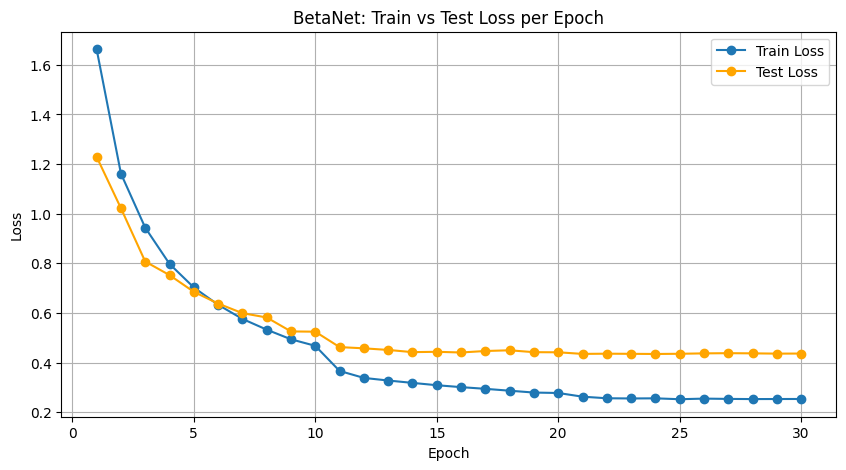

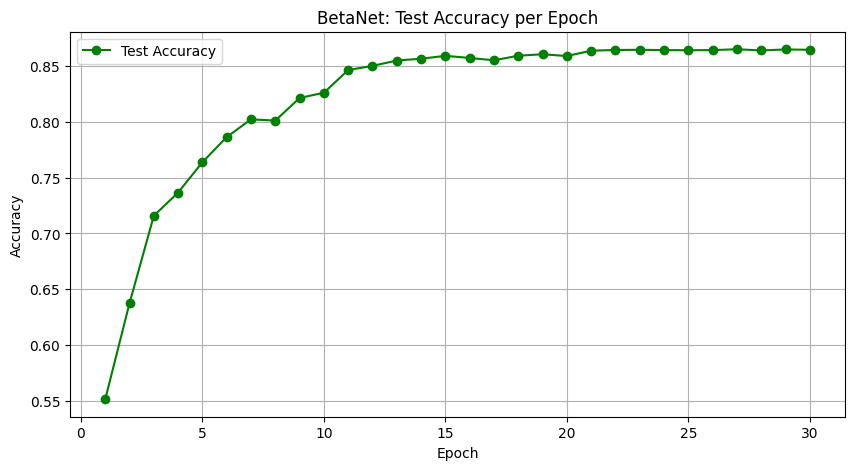

In [59]:
beta_metrics = train_and_evaluate(
    model=betanet_model,
    train_loader=train_loader_beta,
    test_loader=test_loader,
    optimizer=betanet_optimizer,
    criterion=betanet_criterion,
    scheduler=betanet_scheduler,
    epochs=30,
    model_name="BetaNet"
)

### 📊 Analysis


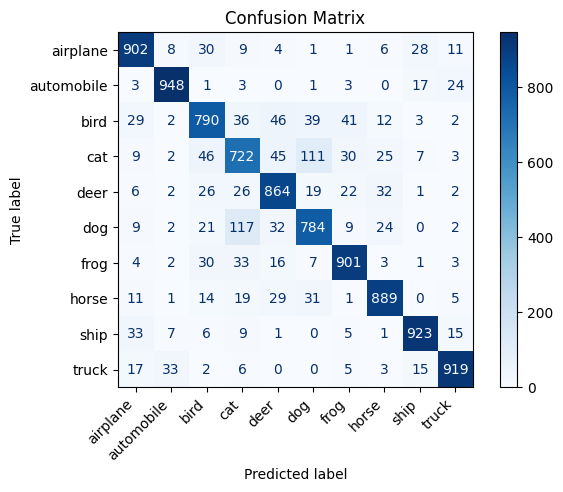

In [64]:
plot_confusion_matrix(betanet_model, test_loader, class_names, device)


In [65]:
classification_report_per_class(betanet_model, test_loader, class_names, device)


              precision    recall  f1-score   support

    airplane       0.88      0.90      0.89      1000
  automobile       0.94      0.95      0.94      1000
        bird       0.82      0.79      0.80      1000
         cat       0.74      0.72      0.73      1000
        deer       0.83      0.86      0.85      1000
         dog       0.79      0.78      0.79      1000
        frog       0.89      0.90      0.89      1000
       horse       0.89      0.89      0.89      1000
        ship       0.93      0.92      0.93      1000
       truck       0.93      0.92      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



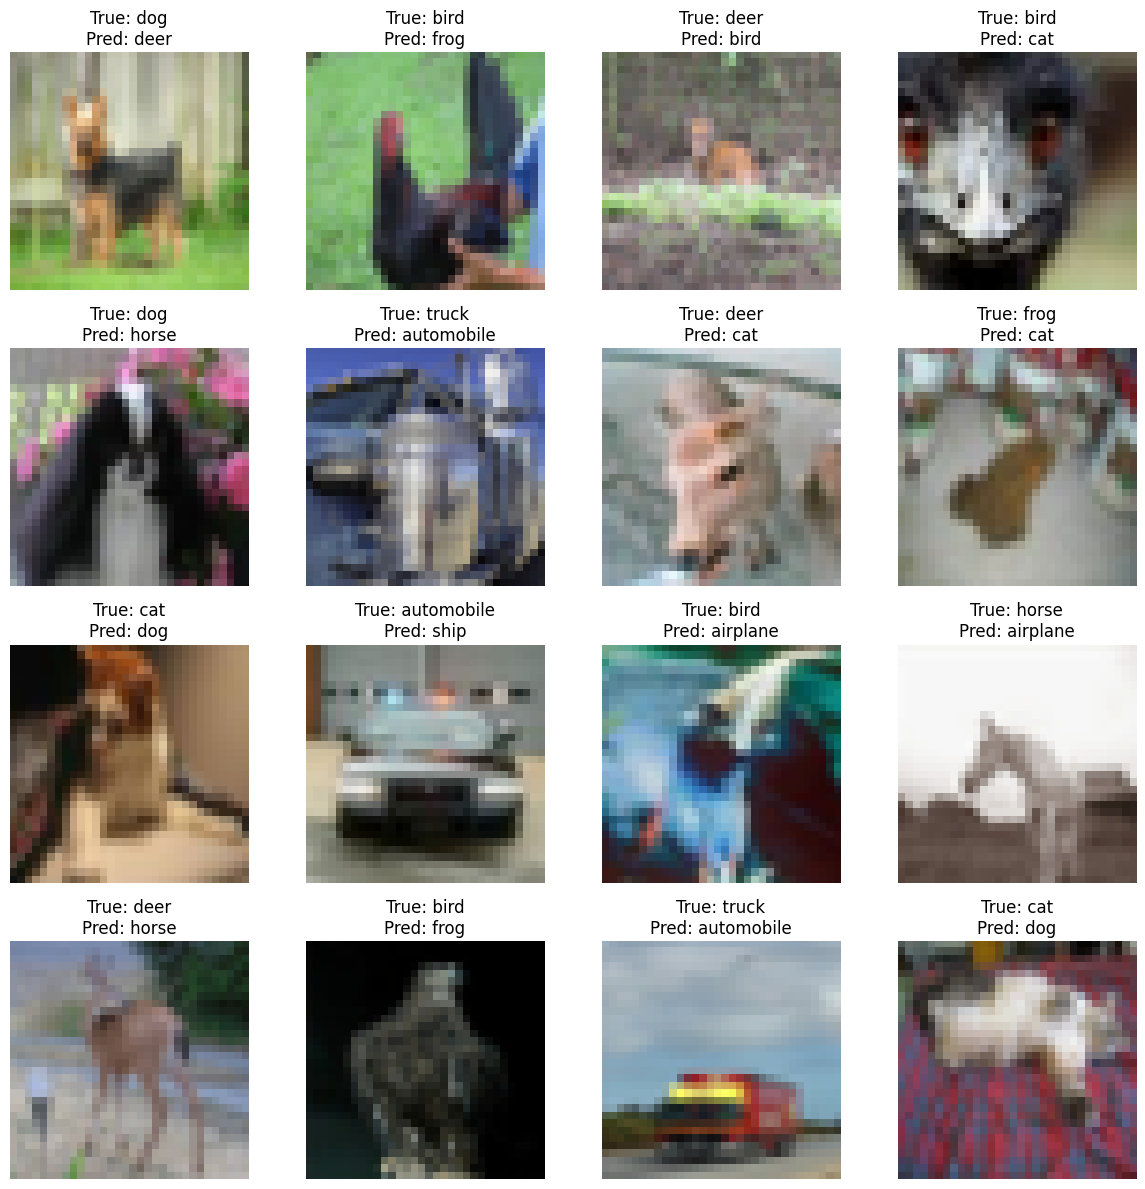

In [66]:
visualize_misclassified_images(betanet_model, test_loader, class_names, device, mean, std)


- **Strengths**:
  - Achieved **85%+ accuracy**, meeting the **VG** requirement.
  - Data augmentations (horizontal flip) helped improve generalization.
- **Weaknesses**:
  - Moderate overfitting despite improved architecture.
  - Slight confusion among animal classes.
- **Observations**:
  - Introduced an additional block (3 total), showing better feature extraction.
  - Performed consistently but struggled to exceed the 86% mark.
- **Suggestions**:
  - Experiment with more advanced augmentations (e.g., colorjitter).
  - Include batch normalization
  - Include dropout to address overfitting.


## 3. 🛡️OmegaNet


### 🔧 Architecture


In [67]:
class Omega(nn.Module):
    def __init__(self):
        super(Omega, self).__init__()

        # 📦 Feature Extractor
        self.feature_extractor = nn.Sequential(
            # 🧠 Block 1
            self._conv_block(3, 64),
            nn.MaxPool2d(2),  # 64x16x16

            # 🧠 Block 2
            self._conv_block(64, 128),
            nn.MaxPool2d(2),  # 128x8x8

            # 🧠 Block 3
            self._conv_block(128, 256),
            nn.MaxPool2d(2),  # 256x4x4

            # 🧠 Block 4
            self._conv_block(256, 512),
            nn.MaxPool2d(2)  # 512x2x2
        )

        # 📝 Fully Connected Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 10)
        )

    def _conv_block(self, in_channels, out_channels):
        """Two-layer convolutional block with BatchNorm and ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


### 🛠️ Initialization


In [71]:
# 🧠 Model, Optimizer, Criterion, and Scheduler
omeganet_model = Omega().to(device)
omeganet_optimizer = Adam(omeganet_model.parameters(), lr=0.001)  # Initial placeholder LR
omeganet_criterion = torch.nn.CrossEntropyLoss()


# Define StepLR scheduler
omeganet_scheduler = StepLR(omeganet_optimizer, step_size=10, gamma=0.1)




### 🖼️ Dataset Visualization


Data training on


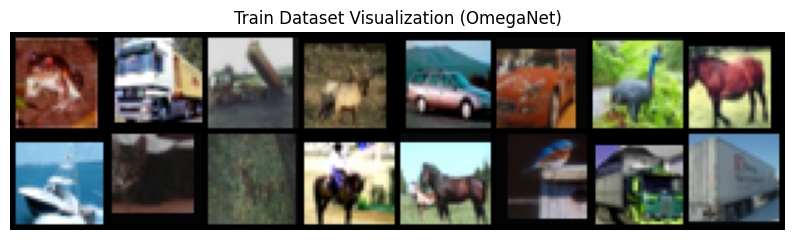

In [69]:
visualize_loader(train_loader_omega_viz, mean, std, title="Train Dataset Visualization (OmegaNet)")

### 🚀 Training


Epoch 1/30 (Learning Rate: 0.001000)


Epoch 1/30: Train Loss = 1.4759, Train Accuracy = 0.4584, Test Loss = 1.1040, Test Accuracy = 0.6142, Learning Rate = 0.001000
Epoch 2/30 (Learning Rate: 0.001000)


Epoch 2/30: Train Loss = 0.9743, Train Accuracy = 0.6603, Test Loss = 0.9746, Test Accuracy = 0.6676, Learning Rate = 0.001000
Epoch 3/30 (Learning Rate: 0.001000)


Epoch 3/30: Train Loss = 0.7708, Train Accuracy = 0.7377, Test Loss = 0.7437, Test Accuracy = 0.7486, Learning Rate = 0.001000
Epoch 4/30 (Learning Rate: 0.001000)


Epoch 4/30: Train Loss = 0.6698, Train Accuracy = 0.7738, Test Loss = 0.7312, Test Accuracy = 0.7613, Learning Rate = 0.001000
Epoch 5/30 (Learning Rate: 0.001000)


Epoch 5/30: Train Loss = 0.5950, Train Accuracy = 0.8015, Test Loss = 0.5969, Test Accuracy = 0.7962, Learning Rate = 0.001000
Epoch 6/30 (Learning Rate: 0.001000)


Epoch 6/30: Train Loss = 0.5402, Train Accuracy = 0.8185, Test Loss = 0.4891, Test Accuracy = 0.8335, Learning Rate = 0.001000
Epoch 7/30 (Learning Rate: 0.001000)


Epoch 7/30: Train Loss = 0.4900, Train Accuracy = 0.8353, Test Loss = 0.5473, Test Accuracy = 0.8138, Learning Rate = 0.001000
Epoch 8/30 (Learning Rate: 0.001000)


Epoch 8/30: Train Loss = 0.4506, Train Accuracy = 0.8482, Test Loss = 0.5464, Test Accuracy = 0.8189, Learning Rate = 0.001000
Epoch 9/30 (Learning Rate: 0.001000)


Epoch 9/30: Train Loss = 0.4185, Train Accuracy = 0.8582, Test Loss = 0.4531, Test Accuracy = 0.8468, Learning Rate = 0.001000
Epoch 10/30 (Learning Rate: 0.001000)


Epoch 10/30: Train Loss = 0.3883, Train Accuracy = 0.8708, Test Loss = 0.4576, Test Accuracy = 0.8458, Learning Rate = 0.000100
Epoch 11/30 (Learning Rate: 0.000100)


Epoch 11/30: Train Loss = 0.2902, Train Accuracy = 0.9035, Test Loss = 0.3093, Test Accuracy = 0.8947, Learning Rate = 0.000100
Epoch 12/30 (Learning Rate: 0.000100)


Epoch 12/30: Train Loss = 0.2618, Train Accuracy = 0.9129, Test Loss = 0.2995, Test Accuracy = 0.8979, Learning Rate = 0.000100
Epoch 13/30 (Learning Rate: 0.000100)


Epoch 13/30: Train Loss = 0.2440, Train Accuracy = 0.9192, Test Loss = 0.2964, Test Accuracy = 0.8995, Learning Rate = 0.000100
Epoch 14/30 (Learning Rate: 0.000100)


Epoch 14/30: Train Loss = 0.2305, Train Accuracy = 0.9235, Test Loss = 0.2982, Test Accuracy = 0.9029, Learning Rate = 0.000100
Epoch 15/30 (Learning Rate: 0.000100)


Epoch 15/30: Train Loss = 0.2280, Train Accuracy = 0.9247, Test Loss = 0.2905, Test Accuracy = 0.9037, Learning Rate = 0.000100
Epoch 16/30 (Learning Rate: 0.000100)


Epoch 16/30: Train Loss = 0.2166, Train Accuracy = 0.9281, Test Loss = 0.2976, Test Accuracy = 0.9023, Learning Rate = 0.000100
Epoch 17/30 (Learning Rate: 0.000100)


Epoch 17/30: Train Loss = 0.2084, Train Accuracy = 0.9302, Test Loss = 0.2858, Test Accuracy = 0.9045, Learning Rate = 0.000100
Epoch 18/30 (Learning Rate: 0.000100)


Epoch 18/30: Train Loss = 0.2033, Train Accuracy = 0.9318, Test Loss = 0.2905, Test Accuracy = 0.9063, Learning Rate = 0.000100
Epoch 19/30 (Learning Rate: 0.000100)


Epoch 19/30: Train Loss = 0.1971, Train Accuracy = 0.9343, Test Loss = 0.2907, Test Accuracy = 0.9047, Learning Rate = 0.000100
Epoch 20/30 (Learning Rate: 0.000100)


Epoch 20/30: Train Loss = 0.1894, Train Accuracy = 0.9351, Test Loss = 0.2865, Test Accuracy = 0.9081, Learning Rate = 0.000010
Epoch 21/30 (Learning Rate: 0.000010)


Epoch 21/30: Train Loss = 0.1731, Train Accuracy = 0.9435, Test Loss = 0.2835, Test Accuracy = 0.9081, Learning Rate = 0.000010
Epoch 22/30 (Learning Rate: 0.000010)


Epoch 22/30: Train Loss = 0.1686, Train Accuracy = 0.9444, Test Loss = 0.2809, Test Accuracy = 0.9084, Learning Rate = 0.000010
Epoch 23/30 (Learning Rate: 0.000010)


Epoch 23/30: Train Loss = 0.1646, Train Accuracy = 0.9447, Test Loss = 0.2797, Test Accuracy = 0.9084, Learning Rate = 0.000010
Epoch 24/30 (Learning Rate: 0.000010)


Epoch 24/30: Train Loss = 0.1670, Train Accuracy = 0.9440, Test Loss = 0.2808, Test Accuracy = 0.9084, Learning Rate = 0.000010
Epoch 25/30 (Learning Rate: 0.000010)


Epoch 25/30: Train Loss = 0.1685, Train Accuracy = 0.9439, Test Loss = 0.2788, Test Accuracy = 0.9099, Learning Rate = 0.000010
Epoch 26/30 (Learning Rate: 0.000010)


Epoch 26/30: Train Loss = 0.1659, Train Accuracy = 0.9440, Test Loss = 0.2797, Test Accuracy = 0.9091, Learning Rate = 0.000010
Epoch 27/30 (Learning Rate: 0.000010)


Epoch 27/30: Train Loss = 0.1614, Train Accuracy = 0.9460, Test Loss = 0.2789, Test Accuracy = 0.9104, Learning Rate = 0.000010
Epoch 28/30 (Learning Rate: 0.000010)


Epoch 28/30: Train Loss = 0.1626, Train Accuracy = 0.9458, Test Loss = 0.2814, Test Accuracy = 0.9093, Learning Rate = 0.000010
Epoch 29/30 (Learning Rate: 0.000010)


Epoch 29/30: Train Loss = 0.1613, Train Accuracy = 0.9462, Test Loss = 0.2790, Test Accuracy = 0.9098, Learning Rate = 0.000010
Epoch 30/30 (Learning Rate: 0.000010)


Epoch 30/30: Train Loss = 0.1599, Train Accuracy = 0.9465, Test Loss = 0.2816, Test Accuracy = 0.9100, Learning Rate = 0.000001


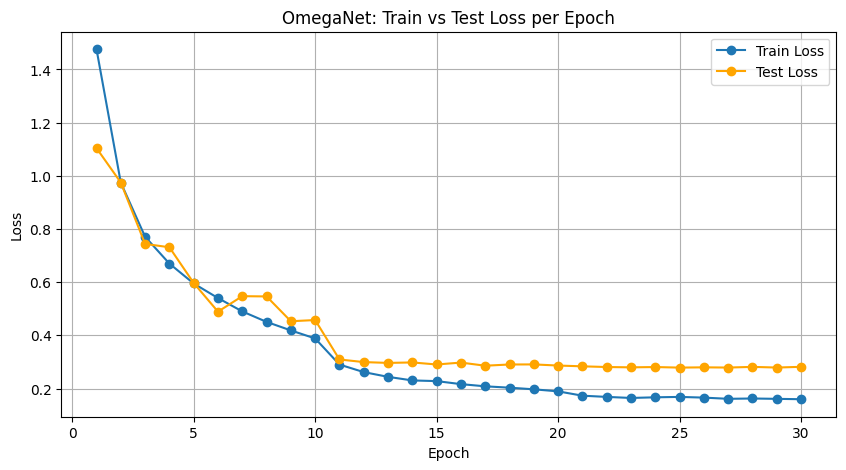

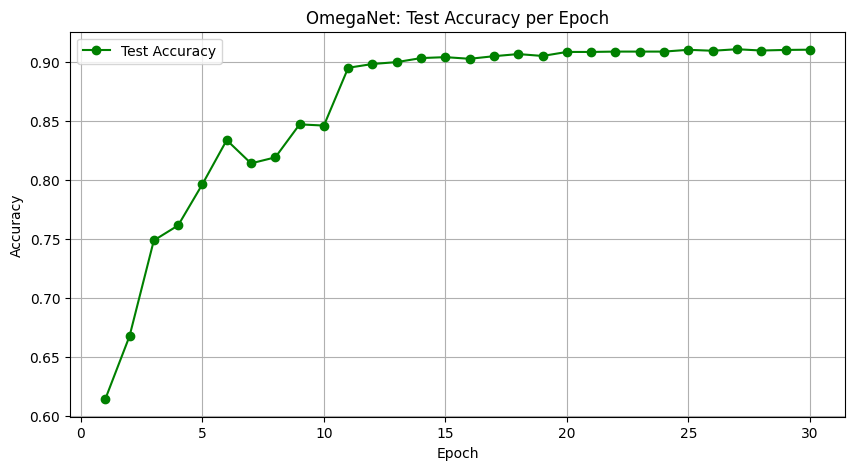

In [72]:
omega_metrics = train_and_evaluate(
    model=omeganet_model,
    train_loader=train_loader_omega,
    test_loader=test_loader,
    optimizer=omeganet_optimizer,
    criterion=omeganet_criterion,
    scheduler=omeganet_scheduler,
    epochs=30,
    model_name="OmegaNet"
)

### 📊 Analysis


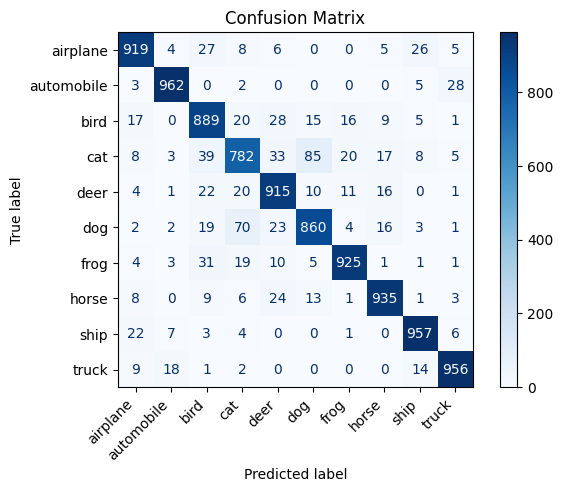

In [73]:
plot_confusion_matrix(omeganet_model, test_loader, class_names, device)


In [74]:
classification_report_per_class(omeganet_model, test_loader, class_names, device)


              precision    recall  f1-score   support

    airplane       0.92      0.92      0.92      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.85      0.89      0.87      1000
         cat       0.84      0.78      0.81      1000
        deer       0.88      0.92      0.90      1000
         dog       0.87      0.86      0.87      1000
        frog       0.95      0.93      0.94      1000
       horse       0.94      0.94      0.94      1000
        ship       0.94      0.96      0.95      1000
       truck       0.95      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



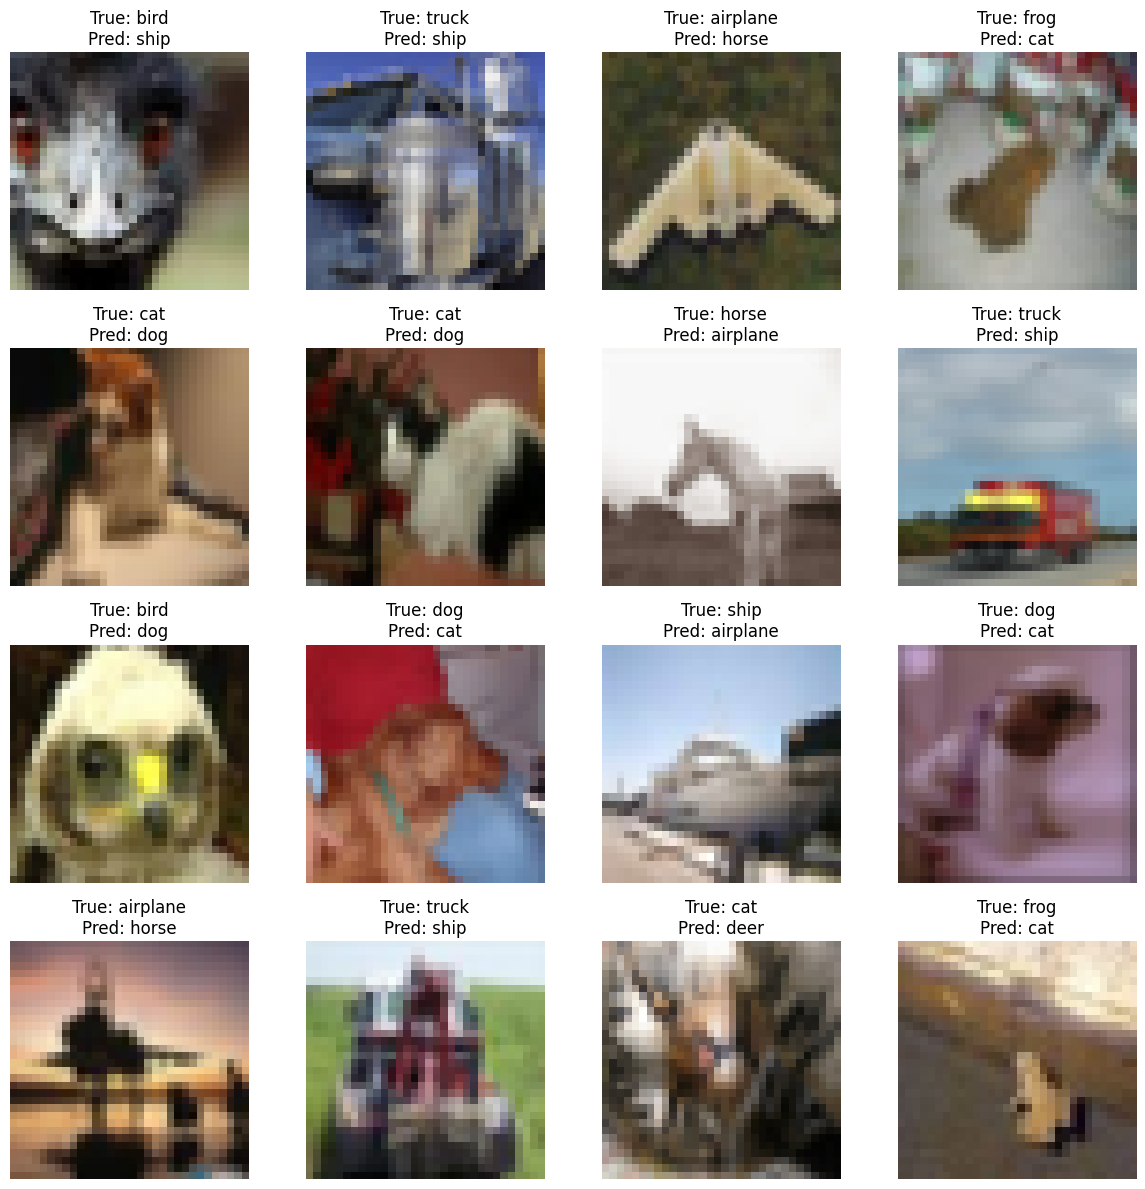

In [75]:
visualize_misclassified_images(omeganet_model, test_loader, class_names, device, mean, std)


---

#🔍 Comparative Analysis Across Models


In this section, we compare the performance of all trained models (AlphaNet, BetaNet, OmegaNet) to evaluate their strengths and weaknesses and determine the best-performing architecture.


### 📊 Model Comparison


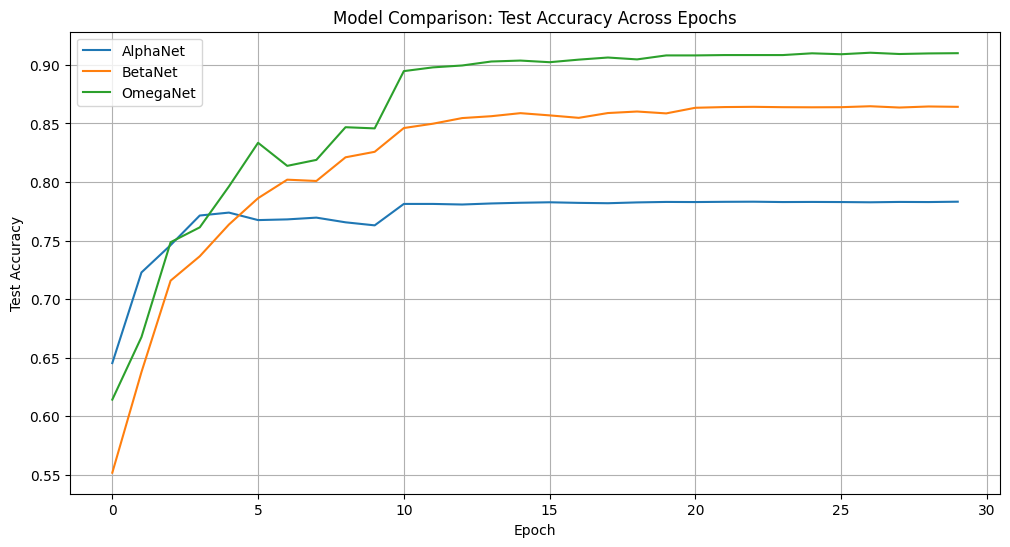

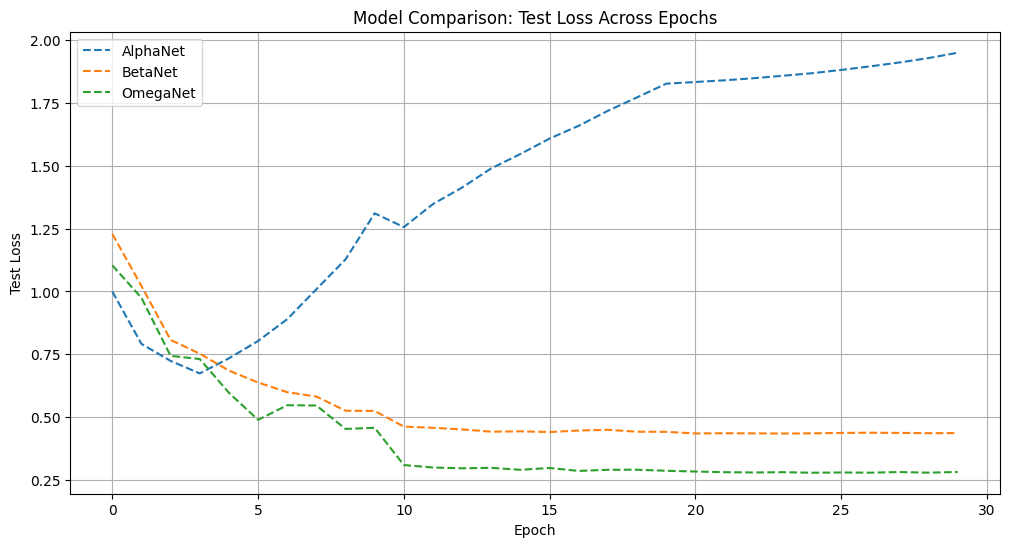

In [76]:
# Test Accuracy Comparison
plt.figure(figsize=(12, 6))
plt.plot(alpha_metrics["test_accuracies"], label="AlphaNet")
plt.plot(beta_metrics["test_accuracies"], label="BetaNet")
plt.plot(omega_metrics["test_accuracies"], label="OmegaNet")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Model Comparison: Test Accuracy Across Epochs")
plt.legend()
plt.grid()
plt.show()

# Test Loss Comparison
plt.figure(figsize=(12, 6))
plt.plot(alpha_metrics["test_losses"], label="AlphaNet", linestyle="--")
plt.plot(beta_metrics["test_losses"], label="BetaNet", linestyle="--")
plt.plot(omega_metrics["test_losses"], label="OmegaNet", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Model Comparison: Test Loss Across Epochs")
plt.legend()
plt.grid()
plt.show()


### 📊 Best Model


In [77]:
summary_data = {
    "Model": ["AlphaNet", "BetaNet", "OmegaNet"],
    "Max Accuracy": [
        max(alpha_metrics["test_accuracies"]),
        max(beta_metrics["test_accuracies"]),
        max(omega_metrics["test_accuracies"]),
    ],
    "Best Epoch": [
        alpha_metrics["test_accuracies"].index(max(alpha_metrics["test_accuracies"])) + 1,
        beta_metrics["test_accuracies"].index(max(beta_metrics["test_accuracies"])) + 1,
        omega_metrics["test_accuracies"].index(max(omega_metrics["test_accuracies"])) + 1,
    ]
}

metrics_df = pd.DataFrame(summary_data)

# Display the table
print(metrics_df)

# Find the best model
best_model_row = metrics_df.loc[metrics_df["Max Accuracy"].idxmax()]
print("\n--- Best Model Summary ---")
print(f"Best Model: {best_model_row['Model']}")
print(f"Best Accuracy: {best_model_row['Max Accuracy'] * 100:.2f}%")
print(f"Achieved at Epoch: {best_model_row['Best Epoch']}")


      Model  Max Accuracy  Best Epoch
0  AlphaNet        0.7832          23
1   BetaNet        0.8647          27
2  OmegaNet        0.9104          27

--- Best Model Summary ---
Best Model: OmegaNet
Best Accuracy: 91.04%
Achieved at Epoch: 27


### Summary of Best Model


In [82]:
print(omeganet_model)

Omega(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

OmegaNet achieves the highest accuracy among all tested architectures, reaching 91% accuracy on the CIFAR-10 test dataset. This performance was due to:

Four convolutional blocks: Each block comprises two convolutional layers followed by BatchNorm and ReLU, with a MaxPool layer to reduce spatial dimensions.
Dropout layers: Dropout is applied in the fully connected layers to mitigate overfitting.
Batch Normalization: Used after every convolutional and dense layer to accelerate training and stabilize learning. Which makes faster convergence and better regularization. Reference Ioffe and Szegedy's paper "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" https://arxiv.org/abs/1502.03167 .

Comprehensive data augmentation: Techniques like RandomCrop, HorizontalFlip, ColorJitter(https://arxiv.org/abs/2408.06741), and RandomErasing improve the generalizability of the model by adding variability. https://arxiv.org/abs/1805.09501

We utilized the Adam optimizer(https://arxiv.org/abs/1412.6980), known for its adaptive learning rates, and paired it with a StepLR scheduler to fine-tune the learning process. While Adam adjusts the learning rates for individual parameters dynamically, the StepLR scheduler decreases the overall learning rate by a factor of gamma at predefined steps (step_size epochs). This combination ensures:

1.  Faster convergence at the beginning due to Adam's adaptive rates.
2.  Stabilization of learning in later epochs when the learning rate decays, helping the model avoid overshooting the minima.


### Performance Visualization


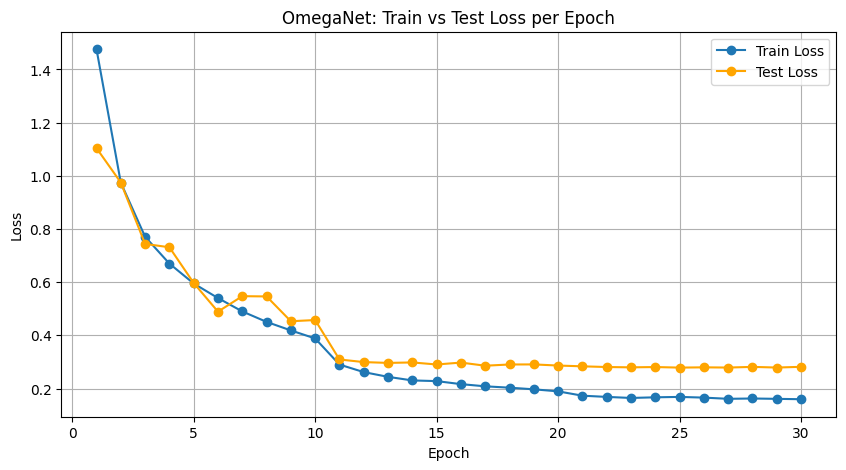

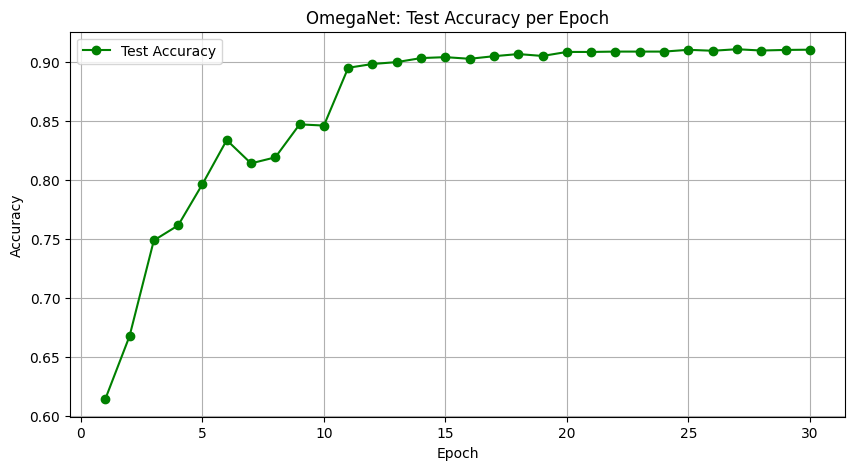

In [86]:
epochs = range(1, len(omega_metrics["train_losses"]) + 1)

# Plot Train vs Test Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, omega_metrics["train_losses"], label="Train Loss", marker="o")
plt.plot(epochs, omega_metrics["test_losses"], label="Test Loss", marker="o", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("OmegaNet: Train vs Test Loss per Epoch")
plt.legend()
plt.grid()
plt.show()
# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, omega_metrics["test_accuracies"], label="Test Accuracy", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("OmegaNet: Test Accuracy per Epoch")
plt.legend()
plt.grid()
plt.show()

### Error Analysis


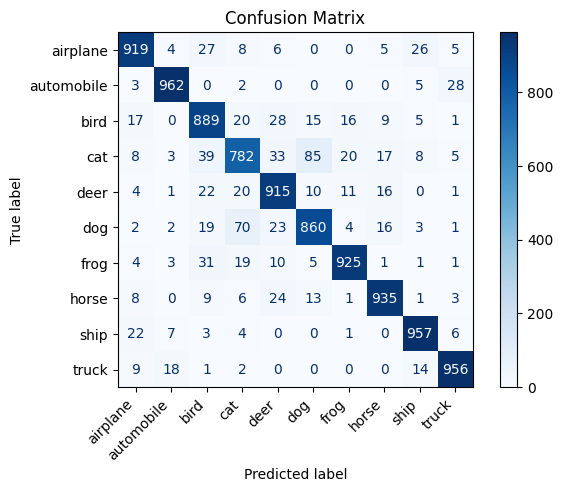

In [89]:
plot_confusion_matrix(omeganet_model, test_loader, class_names, device)


In [90]:
classification_report_per_class(omeganet_model, test_loader, class_names, device)


              precision    recall  f1-score   support

    airplane       0.92      0.92      0.92      1000
  automobile       0.96      0.96      0.96      1000
        bird       0.85      0.89      0.87      1000
         cat       0.84      0.78      0.81      1000
        deer       0.88      0.92      0.90      1000
         dog       0.87      0.86      0.87      1000
        frog       0.95      0.93      0.94      1000
       horse       0.94      0.94      0.94      1000
        ship       0.94      0.96      0.95      1000
       truck       0.95      0.96      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



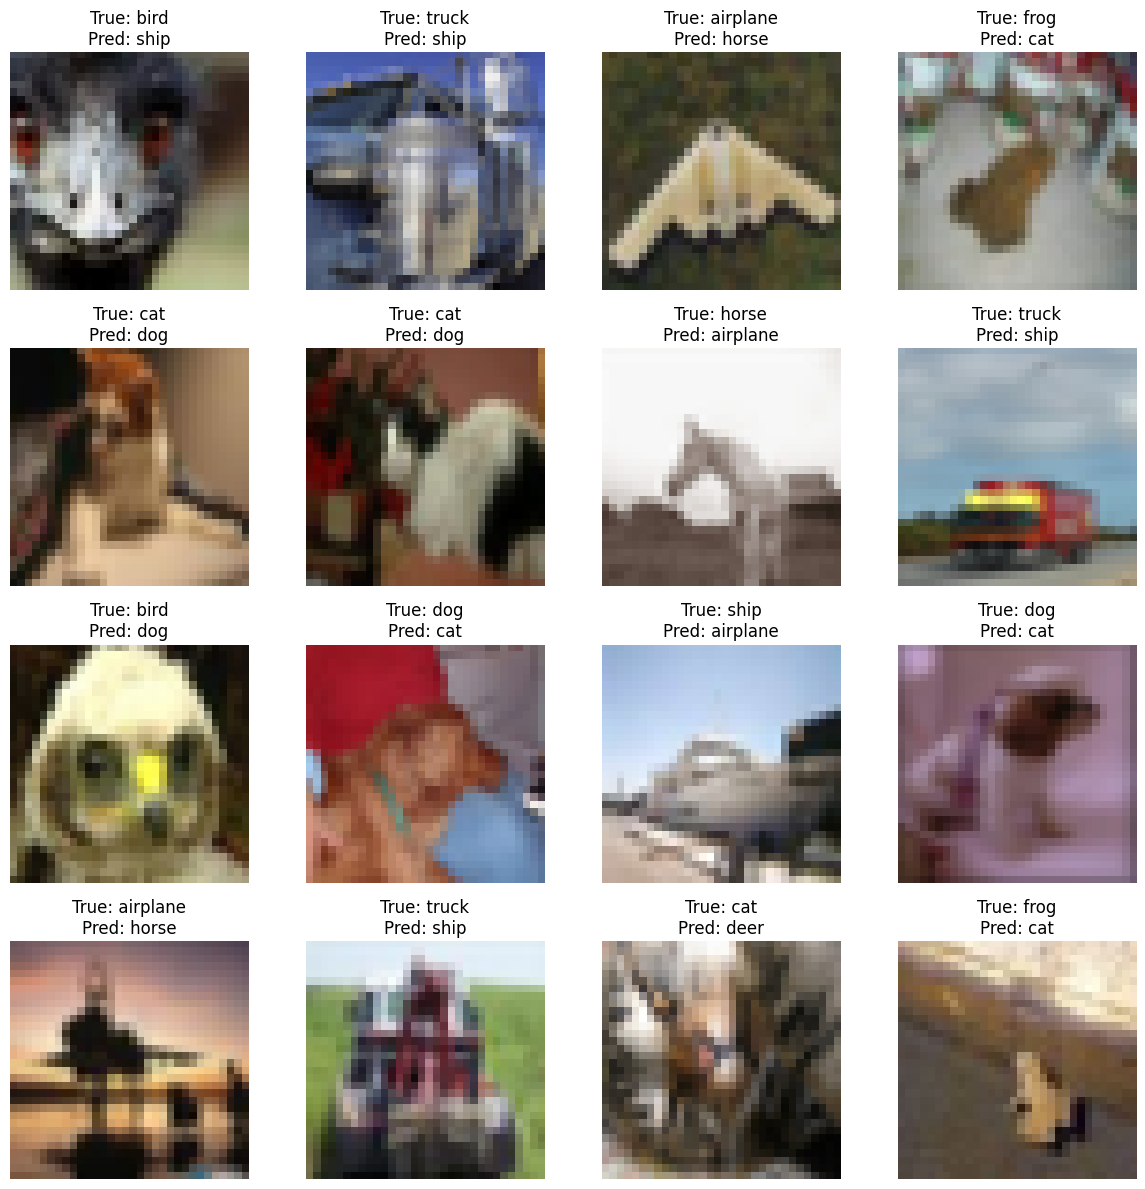

In [91]:
visualize_misclassified_images(omeganet_model, test_loader, class_names, device, mean, std)


- **Strengths**:
  - Achieved **91% accuracy**, surpassing the **Gold Star** requirement.
  - Robust performance across all classes, with well-regularized training.
- **Weaknesses**:
  - Minor misclassifications between "dogs" and "cats."
- **Observations**:
  - Used batch normalization, dropout, and advanced augmentations (e.g., color jitter).
  - Loss convergence and test accuracy were stable throughout training.
- **Suggestions**:
  - Potentially extend epochs or explore fine-tuning for incremental improvements.
  - Consider pretrained models for further accuracy gains.


### Improvement Suggestions


1. **Class-Specific Augmentations**

   - **Observation**: Misclassifications are prevalent between similar classes, such as "dogs" and "cats."
   - **Suggestion**: Introduce **class-specific augmentations** such as:
     - Slight **geometric transformations** (e.g., affine transforms, rotations) that mimic real-world variability.
     - **Color-based augmentations** (e.g., brightness, contrast) to help the model distinguish subtle visual differences.
   - **Goal**: Improve the model's ability to distinguish visually similar classes.

2. **Increase Training Epochs**

   - **Observation**: The model performance plateaus, but with steady improvement up to the final epoch.
   - **Suggestion**: Extend the number of training epochs (e.g., from 30 to 50 or more), while monitoring the loss and accuracy curves.
   - **Goal**: Allow the model to converge more effectively, particularly if using a smaller learning rate after decay.

3. **Add More Convolutional Blocks**

   - **Observation**: The current architecture performs well, but the feature extraction could be enhanced.
   - **Suggestion**: Experiment with adding an additional convolutional block to capture finer image details.
   - **Goal**: Enhance feature extraction for more subtle class distinctions.

4. **Refine Data Augmentation**

   - **Observation**: General augmentations (e.g., random crop, color jitter, random erasing) have improved accuracy.
   - **Suggestion**: Add **MixUp** or **CutMix** techniques, which have shown effectiveness in improving robustness, particularly in cases with overlapping features like "dogs" and "cats."
   - **Goal**: Further improve the model's generalization ability.

5. **Class-Balancing Techniques**

   - **Observation**: If some classes (e.g., "cats") consistently underperform, it could be due to **imbalanced class distributions**.
   - **Suggestion**: Explore **upsampling** or **class-weighted loss functions** to address this imbalance.
   - **Goal**: Ensure underrepresented classes receive more attention during training.

6. **Advanced Pretrained Architectures**
   - **Observation**: The current model (OmegaNet) is custom-built and performs well, but pretrained models (e.g., ResNet) could offer a performance boost.
   - **Suggestion**: Fine-tune a pretrained architecture (e.g., ResNet-50) with additional layers tailored to CIFAR-10.
   - **Goal**: Leverage learned features from large-scale datasets.

---


### Final Summary


1. **Progression and Development**:

   - The journey began with **AlphaNet**, a simple architecture meeting the **G** requirements with minimal augmentations and no regularization. This model laid the foundation for further improvements.
   - **BetaNet** introduced additional convolutional layers and basic augmentations like horizontal flipping, pushing the performance beyond **85% accuracy** and achieving the **VG** requirements.
   - Finally, **OmegaNet** represented a culmination of these efforts, incorporating advanced techniques like batch normalization, dropout, and sophisticated data augmentations (e.g., random erasing, color jitter). These enhancements enabled the model to surpass the **90% accuracy** threshold, meeting the **Gold Star** requirements.

2. **Key Insights**:

   - **Data augmentation** played a significant role in improving generalization, particularly with challenging classes like "dogs" and "cats."
   - **Batch normalization** and **dropout** proved instrumental in stabilizing training and mitigating overfitting in deeper architectures.
   - Iterative improvements in model complexity and training strategies directly translated to higher accuracy and better performance.

3. **Best Model Selection**:

   - **OmegaNet** emerged as the best-performing model with **91% accuracy**, robust performance across all classes, and stable training convergence.

4. **Challenges**:

   - Differentiating visually similar classes like "dogs" and "cats" remained a consistent challenge throughout.
   - Initial models struggled with overfitting, particularly **AlphaNet**, which lacked sufficient regularization.

5. **Future Directions**:
   - Further enhancements could include fine-tuning pretrained models like ResNet for improved accuracy.
   - Exploring cutting-edge augmentations such as **MixUp** or **CutMix** could further enhance performance.
   - Increasing the dataset size or including more varied samples may improve model robustness.

In conclusion, the project demonstrated a clear trajectory of learning and improvement, showcasing how iterative enhancements in architecture, augmentation, and regularization lead to significantly better performance.
